# Grad-CAM

Selvaraju, Ramprasaath R., et al. "Grad-cam: Why did you say that? visual explanations from deep networks via gradient-based localization." arXiv preprint arXiv:1610.02391 (2016).

- CAM 은 마지막 레이어가 GAP 여야 한다는 단점을 가지고 있음
- GradCAM 은 그 단점을 극복한 generalized CAM

![overview](gradcam-overview.png)

## Method

위 그림은 CNN의 마지막에 GAP 가 붙고 linear layer 가 붙어야 하는 CAM 과 달리, Grad-CAM은 CNN 이후에 뭐가 붙든 상관없다는 것을 의미.

![ex1](gradcam-ex1.png)
![ex2](gradcam-ex2.png)

- 위 식에서 $A$ 는 last featuremap 을 의미하고, $y^c$ 는 class c 에 대한 logit 을 의미
- 즉 $\alpha^c_k$ 는 logit 의 각 피처맵에 대한 gradient 의 average 를 의미함
- 이를 직관적으로 설명하면 각 피처맵을 흔들었을 때 logit 이 얼마나 흔들리는가? 를 보는 것
- 이렇게 구한 $a$ 가 각 피처맵에 대한 가중치 weight 가 되며 CAM 에서 linear layer 의 weight 로 구했던 것과 동일함
    - 실제로 GAP 를 마지막에 붙이고 linear layer 를 붙이면 동일한 식이 된다고 함
- ReLU 를 붙인 것은 negative effect feature 는 무시하겠다는 것
    - Q. negative effect 만 visualize 하면 어떨까?
    - 해 봤는데 좀 의미가 불분명함;

## Implementation

- 다른건 별 거 없는데, dy/dA 를 구하는 것이 관건일 듯
- TF 에서는 `tf.gradients()` 가 있는데, PyTorch 에서는?

ref code: https://github.com/kazuto1011/grad-cam-pytorch

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import cv2
import seaborn as sns
from utils import *
from glob import glob
import os
from cluttered_mnist import ClutteredMNISTDataset
from models import ConvLinear, ConvGAP

In [2]:
train_dataset = ClutteredMNISTDataset('../data/mnist_cluttered/', train=True, transform=transforms.ToTensor())
valid_dataset = ClutteredMNISTDataset('../data/mnist_cluttered/', train=False, transform=transforms.ToTensor())

processed dataset already exists; load it
processed dataset already exists; load it


In [3]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [4]:
model = ConvLinear()
model.cuda()

ConvLinear (
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear (4608 -> 256)
  (linear2): Linear (256 -> 10)
)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [6]:
n_epochs = 3

total_loss = AverageMeter()
total_acc = AverageMeter()

for epoch in range(n_epochs):
    total_loss.reset()
    total_acc.reset()
    for X, y in train_loader:
        X = Variable(X).cuda()
        y = Variable(y).cuda()
        
        optimizer.zero_grad()
        y_ = model(X)
        loss = criterion(y_, y)
        loss.backward()
        optimizer.step()
        
        pred = y_.data.max(1)[1]
        
        acc = float(pred.eq(y.data).sum()) / train_loader.batch_size
        total_loss.update(loss.data[0])
        total_acc.update(acc)
    
    print("[TRAIN EPOCH {:2d}]\tLOSS {:.4f}\tACC {:.2%}".format(epoch+1, total_loss.avg, total_acc.avg))
    
    total_loss.reset()
    total_acc.reset()
    for X, y in valid_loader:
        X = Variable(X).cuda()
        y = Variable(y).cuda()
        
        y_ = model(X)
        loss = criterion(y_, y)
        pred = y_.data.max(1)[1]
        acc = float(pred.eq(y.data).sum()) / valid_loader.batch_size
        total_loss.update(loss.data[0])
        total_acc.update(acc)
    
    print("[VALID EPOCH {:2d}]\tLOSS {:.4f}\tACC {:.2%}".format(epoch+1, total_loss.avg, total_acc.avg))

[TRAIN EPOCH  1]	LOSS 1.0222	ACC 62.57%
[VALID EPOCH  1]	LOSS 0.2557	ACC 91.06%
[TRAIN EPOCH  2]	LOSS 0.1625	ACC 94.91%
[VALID EPOCH  2]	LOSS 0.1284	ACC 94.92%
[TRAIN EPOCH  3]	LOSS 0.0946	ACC 96.91%
[VALID EPOCH  3]	LOSS 0.0966	ACC 95.91%


## Grad-CAM

## Add gradient hook

- dy/dA 를 y.backward() 로 계산할 수 있는데, 저 값에 접근하려면 hook 을 달아서 접근해야 함
- 이렇게 계산하면 좀 낭비가 있는데 효율적으로 A 까지만 gradient 를 계산할 수 있나?

In [7]:
forwards = []
grads = []

def fw_hook(module, inputs, outputs):
    forwards.append({
        'module': module,
        'input': inputs,
        'output': outputs
    })

def bw_hook(module, grad_in, grad_out):
    '''
    grad_in: module 의 input 의 gradient.
    grad_out: module 의 output 의 gradient.
    
    --
    따라서 conv3 의 결과의 gradient 를 얻고 싶다면 grad_out 으로 하는 게 맞음. 
    여기서 grad_in 은 (conv2-relu-)maxpool 의 gradient 에 해당하게 된다.
    '''
    
    # add gradient to grads list
    grads.append({
        'module': module,
        'grad_in': grad_in,
        'grad_out': grad_out
    })

# clear hooks
def clear_hooks(model):
    for module in model.modules():
        module._forward_hooks.clear()
        module._backward_hooks.clear()
        
        
clear_hooks(model)

# add hook
for name, module in list(model.named_modules())[::-1]: # reverse 
    if name.startswith('conv'): # last featuremap
        print "{} is last featuremap".format(name)
        module.register_forward_hook(fw_hook)
        module.register_backward_hook(bw_hook)
        break

conv4 is last featuremap


## Calc & Visualize GradCAM

In [8]:
def get_alpha(grad_last_fmap):
    """
    return GAP(grad_last_fmap)
    which indicates weights of channels.
    
    CAM 에서의 weight.
    gradient of last featuremap 의 GAP 값 (채널별 평균).
    각 채널별 가중치가 됨.
    """
    n_channels = grad_last_fmap.size(1)
    alpha = grad_last_fmap.squeeze().view(n_channels, -1).mean(1) # GAP of gradients: flatten & mean
    
    return alpha

In [9]:
def get_activ_map(alpha, last_fmap, reverse=False):
    """
    각 채널의 가중치 alpha 와,
    last featuremap 을 받아서 activation map 계산.
    """
    weighted_fmap = alpha.view(-1, 1, 1)*last_fmap.squeeze()
    activ_map = weighted_fmap.sum(0)
    if reverse:
        activ_map = -activ_map
    activ_map_relu = F.relu(activ_map)
    
    return activ_map_relu

In [10]:
def postproc(activ_map):
    """ normalize 
    activ_map 자체가 relu 를 통과한 결과이므로 min 은 0이라고 보면 max 로만 나누어주면 됨
    """
    amap = activ_map.data.cpu().numpy()
    amap = amap / (amap.max() + 1e-8) # for numerical stability
    return amap

In [11]:
def GradCAM(model, idx, reverse=False):
    del forwards[:], grads[:] # clear
    X, y = valid_dataset[idx]
    X_var = Variable(X.unsqueeze(0)).cuda() ## add batch dim
    y_ = model(X_var)
    pred = y_.data.max(1)[1] # [B]
    pred = pred[0] # []
    
    print "Pred {} (real {})".format(pred, y)
    
    model.zero_grad()
    y_[:, pred].backward()
    last_fmap = forwards[-1]['output'][0]
    grad_last_fmap = grads[-1]['grad_out'][0]
    
    alpha = get_alpha(grad_last_fmap)
    activ_map = get_activ_map(alpha, last_fmap, reverse=reverse)
    activ_map = postproc(activ_map)
    
    visualize(X.numpy(), activ_map)

In [12]:
def visualize(X, activ_map):
    X = X.squeeze().transpose([1, 2, 0]) # CHW => HWC
    activ_map = cv2.resize(activ_map, tuple(X.shape[:2]), interpolation=cv2.INTER_LINEAR)
    activ_map_int = (activ_map*255).astype(np.uint8)
    heatmap = cv2.cvtColor(cv2.applyColorMap(activ_map_int, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
    heatmap_float = heatmap.astype(np.float32)/255.
    overlay = X*0.5 + heatmap_float*0.3
    
    fig = plt.figure(figsize=(12, 6))
    plt.jet()
    
    # org
    plt.subplot(1, 4, 1)
    plt.imshow(X, vmin=0., vmax=1., cmap='Greys_r')
    plt.axis('off')

    # hot
    plt.subplot(1, 4, 2)
    plt.imshow(activ_map, vmin=0., vmax=1., cmap=plt.cm.hot)
    plt.axis('off')
    
    # jet + colorbar
    plt.subplot(1, 4, 3)
    heatmap_im = plt.imshow(heatmap)
    plt.colorbar(heatmap_im, fraction=0.046, pad=0.04)
    plt.axis('off')
    
    # overlay
    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.axis('off')
    
    plt.show()

Pred 1 (real 1)


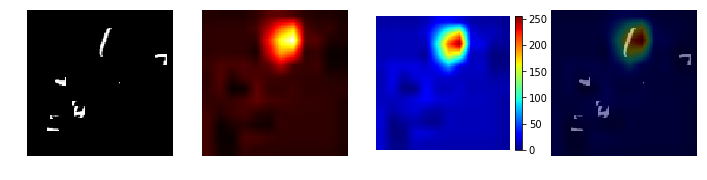

---


In [13]:
for i in range(1):
    GradCAM(model, i)
#     GradCAM(model, i, reverse=True) # check about negative effect objects
    print "---"

# Ref - same results ...

In [ ]:
# import copy
# from gradcam import GradCAM

# # modify model in the GradCAM module
# copy_model = ConvLinear()
# copy_model.load_state_dict(copy.deepcopy(model.state_dict()))
# gcam = GradCAM(model=copy_model, cuda=True)

In [ ]:
# X, y = valid_dataset[1]
# X_var = Variable(X.unsqueeze(0)).cuda()

# probs, idx = gcam.forward(X_var)
# gcam.backward(idx=idx[0])
# output = gcam.generate(target_layer='conv3')

# fig = plt.figure(figsize=(8, 4))
# plt.subplot(1, 2, 1)
# plt.imshow(X.numpy().transpose([1, 2, 0]))
# plt.subplot(1, 2, 2)
# plt.imshow(output)
# plt.show()